<a href="https://colab.research.google.com/github/Yamana06/NYC-Taxi-Trip-Duration/blob/main/NYC_Taxi_Trip_Duration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Required Libraries
First we will import all the necessary libraries needed for analysis and visualization.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings; warnings.simplefilter('ignore')
from geopy.distance import great_circle


<b>Now that we have all the necessary libraries lets load the data set. We will load it into the pandas DataFrame df.

In [4]:
df=pd.read_csv("/content/drive/MyDrive/Project-1/NYC Taxi Data.csv")

<b>We read the dataset into the DataFrame df and will have a look at the shape , columns , column data types and the first 5 rows of the data. This will give a brief overview of the data at hand.

In [5]:
df.shape # This returns the number of rows and columns


(1458644, 11)

In [6]:
df.columns # This returns the column names

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

#### Here’s what we know about the columns:<br>

<b>Demographic information of Customer & Vendor:<br>
- id : a unique identifier for each trip<br>
- vendor_id : a code indicating the provider associated with the trip record<br>
- passenger_count : the number of passengers in the vehicle (driver entered value)<br>

<b>Information about the Trip:<br>
- pickup_longitude : date and time when the meter was engaged<br>
- pickup_latitude : date and time when the meter was disengaged<br>
- dropoff_longitude : the longitude where the meter was disengaged<br>
- dropoff_latitude : the latitude where the meter was disengaged<br>
- store_and_fwd_flag : This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)<br>
- trip_duration : (target) duration of the trip in seconds<br>
<br>
- <b>Thus we have a data set with 1458644 rows and 11 columns. There are 10 features and 1 target variable which is trip_duration

In [7]:
df.dtypes #This returns the data type of the columns

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

<b>Some observations about the data:<br>
- The columns id and vendor_id are nominal.<br>
- The columns pickup_datetime and dropoff_datetime are stored as object which must be converted to datetime for better analysis.<br>
- The column store_and_fwd_flag is categorical<br>

In [8]:
df.head() #This returns the first 5 rows of the Data set

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


- Thus we get a glimpse of the data set by looking at the first 5 rows returned by df.head(). Optionally we can specify the number of rows to be returned, by sending it as a parameter to the head() function.

<b>Lets look at the numerical columns :

In [9]:
print(df.count())

id                    1458644
vendor_id             1458644
pickup_datetime       1458644
dropoff_datetime      1458644
passenger_count       1458644
pickup_longitude      1458644
pickup_latitude       1458644
dropoff_longitude     1458644
dropoff_latitude      1458644
store_and_fwd_flag    1458644
trip_duration         1458644
dtype: int64


<br>

- Let us finally check for a statistical summary of our dataset.
- Note that this function can provide statistics for numerical features only.

In [10]:
df.describe().apply(lambda s:s.apply('{0:.2f}'.format)) # This returns a statistical summary of the numerical columns

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00
mean,1.53,1.66,-73.97,40.75,-73.97,40.75,959.49
std,0.50,1.31,0.07,0.03,0.07,0.04,5237.43
min,1.00,0.00,-121.93,34.36,-121.93,32.18,1.00
25%,1.00,1.00,-73.99,40.74,-73.99,40.74,397.00
50%,2.00,1.00,-73.98,40.75,-73.98,40.75,662.00
75%,2.00,2.00,-73.97,40.77,-73.96,40.77,1075.00
max,2.00,9.00,-61.34,51.88,-61.34,43.92,3526282.00


<b>The returned table gives certain insights:<br>
- Passenger count has a minimum of 0 which means either it is an error entered or the drivers deliberately entered 0 to complete a target number of rides.
- The passenger count varies between 1 and 9 with most people number of people being 1 or 2
- The trip duration varying from 1s to 3526282s~ 979 hrs. There are definitely some outliers present which must be treated.

# Let us see if there are any null values in our dataset.

In [11]:
df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

### There are no null values in this dataset which saves us a step of imputing.


# Let us check for unique values of all columns.

In [12]:
df.nunique()

id                    1458644
vendor_id                   2
pickup_datetime       1380222
dropoff_datetime      1380377
passenger_count            10
pickup_longitude        23047
pickup_latitude         45245
dropoff_longitude       33821
dropoff_latitude        62519
store_and_fwd_flag          2
trip_duration            7417
dtype: int64

- We see that id has 729322 unique values which are equal to the number of rows in our dataset.
- There are 2 unique vendor ids.
- There are 9 unique passenger counts.
- There are 2 unique values for store_and_fwd_flag, that we also saw in the description of the variables, which are Y and N.

## Feature Creation
Let us create some new features from the existing variables so that we can gain more insights from the data.

Remember pickup_datetime and dropoff_datetime were both of type object.
If we want to make use of this data, we can convert it to datetime object which contains numerous functions with which we can create new features that we will see soon.

In [13]:
df['pickup_datetime']=pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime']=pd.to_datetime(df['dropoff_datetime'])

# let us extract and create new features from this datetime features 

In [14]:
df['pickup_day']=df['pickup_datetime'].dt.day_name()
df['dropoff_day']=df['dropoff_datetime'].dt.day_name()

We have created the following feature:
- pickup_day and dropoff_day which will contain the name of the day on which the ride was taken.

In [15]:
df['pickup_day_no']=df['pickup_datetime'].dt.weekday
df['dropoff_day_no']=df['dropoff_datetime'].dt.weekday

We have created the following feature:
- pickup_day_no and dropoff_day_no which will contain the day number instead of characters with Monday=0 and Sunday=6.

In [16]:
df['pickup_hour']=df['pickup_datetime'].dt.hour
df['dropoff_hour']=df['dropoff_datetime'].dt.hour

We have created the following feature:
- pickup_hour and dropoff_hour with an hour of the day in the 24-hour format.

In [17]:
df['pickup_month']=df['pickup_datetime'].dt.month
df['dropoff_month']=df['dropoff_datetime'].dt.month

We have created the following feature:
- pickup_month and dropoff_month with month number with January=1 and December=12.

Lets us determine what time of the day the ride was taken. I have created 4 time zones ‘Morning’ (from 6:00 am to 11:59 pm), ‘Afternoon’ (from 12 noon to 3:59 pm), ‘Evening’ (from 4:00 pm to 9:59 pm), and ‘Late Night’ (from 10:00 pm to 5:59 am)

In [18]:
def time_of_day(x):
    if x in range(6,12):
        return 'Morning'
    elif x in range(12,16):
        return 'Afternoon'
    elif x in range(16,22):
        return 'Evening'
    else:
        return 'Late night'

df['pickup_timeofday']=df['pickup_hour'].apply(time_of_day)
df['dropoff_timeofday']=df['dropoff_hour'].apply(time_of_day)

- We also saw during dataset exploration that we have coordinates in the form of longitude and latitude for pickup and dropoff. But, we can’t really gather any insights or draw conclusions from that.
So, the most obvious feature that we can extract from this is distance.

In [19]:
def cal_distance(pickup_lat,pickup_long,dropoff_lat,dropoff_long):
    start_coordinates=(pickup_lat,pickup_long)
    stop_coordinates=(dropoff_lat,dropoff_long)
    return great_circle(start_coordinates,stop_coordinates).km


In [20]:
df['distance'] = df.apply(lambda x: cal_distance(x['pickup_latitude'],x['pickup_longitude'],x['dropoff_latitude'],x['dropoff_longitude'] ),axis=1)

In [21]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_day,pickup_day_no,dropoff_day_no,pickup_hour,dropoff_hour,pickup_month,dropoff_month,pickup_timeofday,dropoff_timeofday,distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,Monday,0,0,17,17,3,3,Evening,Evening,1.498523
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,Sunday,6,6,0,0,6,6,Late night,Late night,1.805510
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,Tuesday,1,1,11,12,1,1,Morning,Afternoon,6.385108
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,Wednesday,2,2,19,19,4,4,Evening,Evening,1.485501
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,Saturday,5,5,13,13,3,3,Afternoon,Afternoon,1.188590


# Univariate Analysis
Lets have a look at the distribution of various variables in the Data set.

# Let us start by analyzing the target variable.

In [ ]:
sns.histplot(df['trip_duration'],kde=False,bins=20)
plt.title('      The distribution of of the Pick Up  Duration distribution')

<b>This histogram shows extreme right skewness, hence there are outliers. Lets see the boxplot of this variable.

In [ ]:
sns.boxplot(df['trip_duration'])
plt.title('A boxplot depicting the pickup duration distribution')

#### Thus we see there is only value near 2000000 while all the others are somewhere between 0 and 100000. The one near 2000000 is definitely an outlier which must be treated.  We can clearly see an outlier.

In [ ]:
df['trip_duration'].sort_values(ascending=False)

#### Lets have a look at the 10 largest value of trip_duration.

In [ ]:
print( df['trip_duration'].nlargest(10))

- The largest value is much greater than the 2nd and 3rd largest trip duration value. This might be because of some errors which typically occurs during data collection or this might be a legit data. Since the occurrence of such a huge value is unlikely so its better to drop this row before further analysis.

### The value can be replaced by the mode or median of trip duration as well.

In [ ]:
df=df[df.trip_duration!=df.trip_duration.max()]

### The distribution of the trip_duration after we have dropped the outlier.

In [ ]:
sns.distplot(df['trip_duration'])
plt.title('               Distribution of the pickup ditribution after the treatment of outliers')

###  Still there is an extreme right skewness. Thus we will divide the trip_duration column into some interval.
<b>The intervals are decided as follows:
- less than 5 hours
- 5–10 hours
- 10–15 hours
- 15–20 hours
- more than 20 hours

In [ ]:
bins=np.array([0,1800,3600,5400,7200,90000])
df['duration_time']=pd.cut(df.trip_duration,bins,labels=["< 5", "5-10", "10-15","15-20",">20"])

## Passenger Count

In [ ]:
df.passenger_count.value_counts()

- There are some trips with even 0 passenger count that means the booking might be cancelled due to some reason.
- There is only 1 trip each for 7 and 9 passengers.

In [ ]:
# A histogram of the passengers in each trip
sns.distplot(df['passenger_count'],kde=False)
plt.title('Distribution of Passenger Count')
plt.show()

- Here we see that the mostly 1 or 2 passengers avail the cab. The instance of large group of people travelling together is rare.

<b>Let us remove the rows which have 0 or 7 or 8 or 9 passenger count.

In [ ]:
df=df[df['passenger_count']!=0]
df=df[df['passenger_count']<=6]

In [ ]:
df.passenger_count.value_counts()

- Now, that seems like a fair distribution.

# Store and Forward Flag

In [33]:
#The returned frequency distribution of the Yes/No Flag
df['store_and_fwd_flag'].value_counts() 

N    1450536
Y       8042
Name: store_and_fwd_flag, dtype: int64

- The number of N flag is much larger. We can later see whether they have any relation with the duration of the trip.

# Distance

In [34]:
df['distance'].value_counts()

0.000000    5887
0.000424      45
0.000424      43
0.000424      35
0.000424      22
            ... 
3.231345       1
1.584861       1
0.434274       1
3.809274       1
1.134044       1
Name: distance, Length: 1452308, dtype: int64

### We see there are 5887 trips with 0 km distance.

The reasons for 0 km distance can be:
- The dropoff location couldn’t be tracked.
- The driver deliberately took this ride to complete a target ride number.
- The passengers canceled the trip.<br>

We will analyze these trips further in bivariate analysis.

# Vendor id

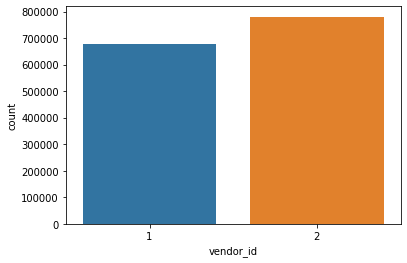

In [35]:
sns.countplot(x='vendor_id',data=df)

- We see that there is not much difference between the trips taken by both vendors.

# Trips per Day

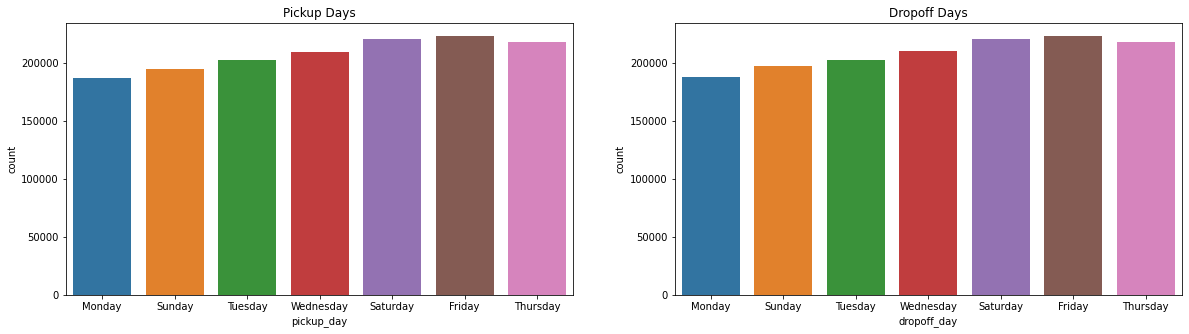

In [36]:
figure,(ax1,ax2)=plt.subplots(ncols=2,figsize=(20,5))
ax1.set_title('Pickup Days')
ax=sns.countplot(x="pickup_day",data=df,ax=ax1)
ax2.set_title('Dropoff Days')
ax=sns.countplot(x="dropoff_day",data=df,ax=ax2)

- Thus we see most trips were taken on Friday and Monday being the least. 
- We see Fridays are the busiest days followed by Saturdays. That is probably because it’s weekend.

# Trips per Hour

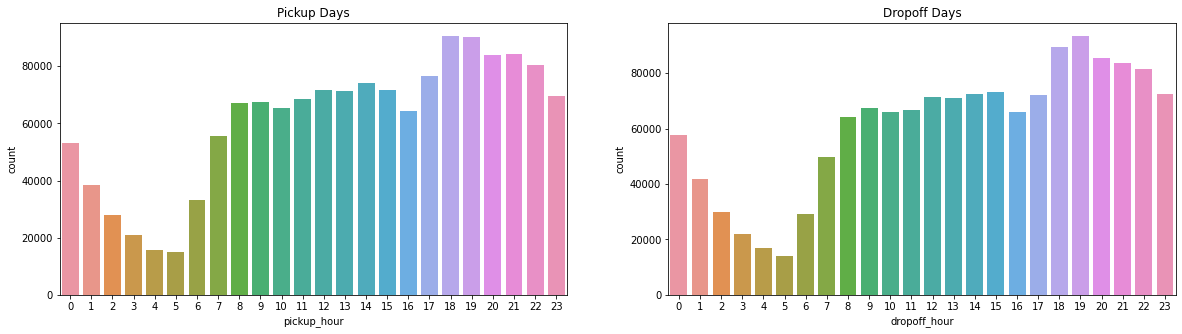

In [37]:
figure,(ax9,ax10)=plt.subplots(ncols=2,figsize=(20,5))
ax9.set_title('Pickup Days')
ax=sns.countplot(x="pickup_hour",data=df,ax=ax9)
ax10.set_title('Dropoff Days')
ax=sns.countplot(x="dropoff_hour",data=df,ax=ax10)

- We see the busiest hours are 6:00 pm to 7:00 pm and that makes sense as this is the time when people return from their offices.

# Trips per Time of Day

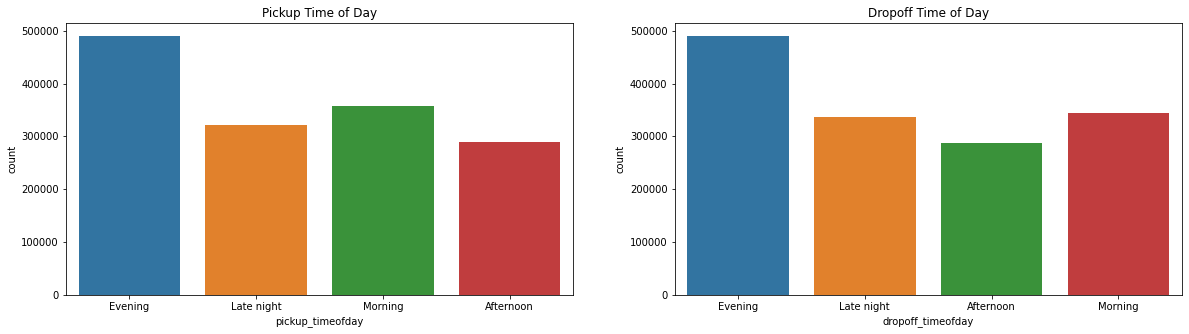

In [38]:
figure,(ax3,ax4)=plt.subplots(ncols=2,figsize=(20,5))
ax3.set_title('Pickup Time of Day')
ax=sns.countplot(x="pickup_timeofday",data=df,ax=ax3)
ax4.set_title('Dropoff Time of Day')
ax=sns.countplot(x="dropoff_timeofday",data=df,ax=ax4)

- Thus we observe that most pickups and drops occur in the evening. While the least drops and pickups occur during morning.

# Trips per month

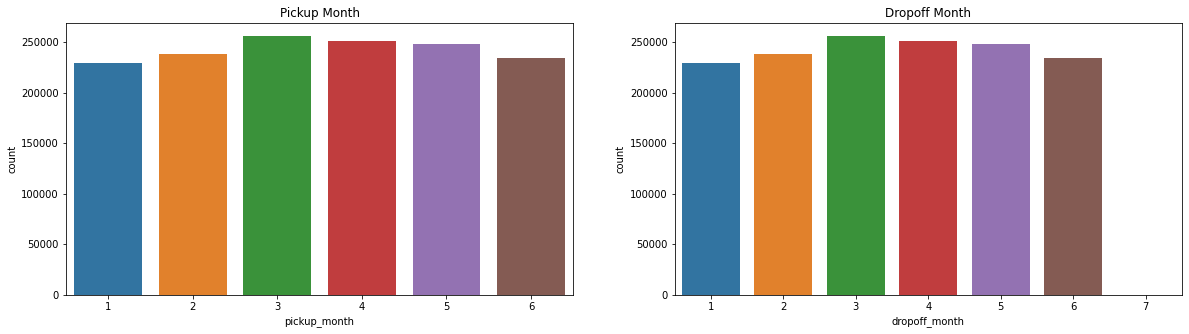

In [39]:
figure,(ax11,ax12)=plt.subplots(ncols=2,figsize=(20,5))
ax11.set_title('Pickup Month')
ax=sns.countplot(x="pickup_month",data=df,ax=ax11)
ax12.set_title('Dropoff Month')
ax=sns.countplot(x="dropoff_month",data=df,ax=ax12)

- There is not much difference in the number of trips across months.

# Bivariate Analysis<br>

# Passenger Count and Vendor id

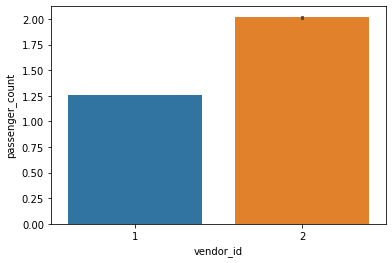

In [40]:
sns.barplot(y='passenger_count',x='vendor_id',data=df)

### Most People Preferred Vendor 2 For Booking Cab Services that can lead to the Thinking part:
- There might be either shortage of Taxi provided by vendor 1.
- Or There might be good service Provided by Vendor B as compared to A.Lets investigate by drawing catplot.

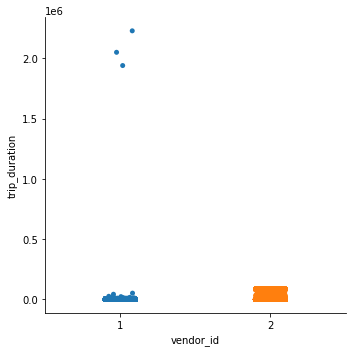

In [41]:
sns.catplot(y='trip_duration', x='vendor_id',data=df,kind='strip')

- Vendor 1 Offer Short Trips.Where as Vendor 2 offer short as well as long trips thats why people preferred more Vendor 2.
- Vendor id 2 takes longer trips as compared to vendor 1.

# Passenger Count and Trip Duration 

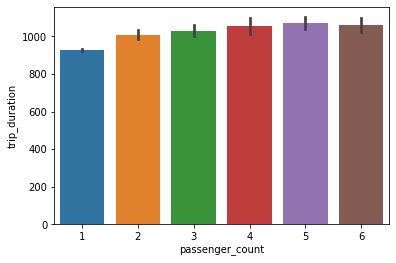

In [42]:
sns.barplot(x= 'passenger_count', y= "trip_duration",data=df)

- Most of the Passenger Trip Duration is b/w 800 to 1000 sec.
- The lowest trip duration is around 0 that might be an outlier or people might have cancelled after booking.

# Trip Duration per Store and Forward Flag 

In [ ]:
sns.catplot(y='trip_duration',x='store_and_fwd_flag',data=df,kind='strip')

- Trip duration is generally longer for trips whose flag was not stored.

# Trip Duration per hour

In [ ]:
sns.lineplot(x='pickup_hour',y='trip_duration',data=df)

- We see the trip duration is the maximum around 3 pm which may be because of traffic on the roads.
Trip duration is the lowest around 6 am as streets may not be busy.

# Trip Duration per time of day

In [ ]:
sns.lineplot(x='pickup_timeofday',y='trip_duration',data=df)

- As we saw above, trip duration is the maximum in the afternoon and lowest between late night and morning.

# Trip Duration per Day of Week

In [ ]:
sns.catplot(x="pickup_day",y="trip_duration",kind="bar",data=df,height=6,aspect=1)
plt.title('The Average Trip Duration per PickUp Day of the week')
sns.catplot(x="dropoff_day",y="trip_duration",kind="bar",data=df,height=6,aspect=1)
plt.title('The Average Trip Duration per Dropoff Day of the week')

- The graphs denote the average estimate of a trip for each day of the week. The error bars provides some indication of the uncertainty around that estimate

- Thus the highest avg time taken to complete a trip is on Thursday while Monday, Saturday and Sunday takes the least time.

- But this is not enough. We must also take into consideration the percentage of short, medium and long trips taken on each day.

In [ ]:
ax1=df.groupby('pickup_day')['duration_time'].value_counts(normalize=True).unstack()
ax1.plot(kind='bar', stacked='True')
plt.title('The Distribution of percentage of different duration of trips')

- The graph shows a percentage distribution of the trips of different duration within each day of the week.

- This does not give much insights as the number of trips within 0–5 hours range is much larger for all the days,

- Lets look at the percentage of only longer trips (with duration time > 5 hours)

In [ ]:
figure,ax=plt.subplots(nrows=1,ncols=3,figsize=(15,5))
ax1=df[(df.duration_time !="< 5")].groupby('pickup_day')['duration_time'].count()
ax1.plot(kind='bar',ax=ax[0])
ax[0].set_title('Distribution of trips > 5 hours')
ax2=df[(df.duration_time !="< 5")].groupby('pickup_day')['duration_time'].value_counts(normalize=True).unstack()
ax2.plot(kind='bar', stacked='True',ax=ax[1])
ax[1].set_title('Percentage distribution of trips > 5 hours')
ax3=df[(df.duration_time !="< 5")].groupby('pickup_day')['duration_time'].value_counts().unstack()
ax3.plot(kind='bar',ax=ax[2])
ax[2].set_title('A compared distribution of trips > 5 hours')

- The 3 graphs present 3 types of information here:

- The left most graph shows a frequency distribution of the number of trips(> 5 hours ) taken on each day of the week

- The middle one shows a percentage distribution of the trips of different duration ( > 5 hours )within each day of the week.

- The right one shows the frequency distribution of the trips of different duration (> 5 hours)within each day of the week.

## Some key points :
- The most number trips which lasts > 5 hours were taken on Thursday followed by Friday and Wednesday.(Left graph)
- The most number of trips of duration 5–10, 10–15 was taken on Thursday.(right graph)
- But the highest percentage of trips longer than 20 hours was taken on Sunday and Saturday.(middle graph)

# Trip Duration per month

In [ ]:
sns.lineplot(x='pickup_month',y='trip_duration',data=df)

- From February, we can see trip duration rising every month.

# Trip Duration and Distance

In [ ]:
sns.relplot(y=df.distance,x='trip_duration',data=df)

- We can see there are trips which trip duration as short as 0 seconds and yet covering a large distance. And, trips with 0 km distance and long trip durations.

#### Let us see few rows whose distances are 0.

In [ ]:
df[df.distance==0].head()

In [ ]:
df[df.distance==0].tail()

### We can see even though distance is recorded as 0 but trip duration is definitely more.
- One reason can be that the dropoff coordinates weren’t recorded.
- Another reason one can think is that for short trip durations, maybe the passenger changed their mind and cancelled the ride after some time.

# Distance per passenger count

In [ ]:
sns.catplot(y='distance',x='passenger_count',data=df,kind='strip')

- We see some of the longer distances are covered by either 1 or 2 or 4 or 5 passenger rides.


# Distance per day of week

In [ ]:
sns.lineplot(x='pickup_day_no',y='distance',data=df)

- Distances are longer on Sundays probably because it’s weekend.
- Monday trip distances are also quite high.
- This probably means that there can be outstation trips on these days and/or the streets are busier.

# Distance per hour of day

In [ ]:
sns.lineplot(x='pickup_hour',y='distance',data=df)

- Distances are the longest around 5 am.

# Distance per time of day

In [ ]:
sns.lineplot(x='pickup_timeofday',y='distance',data=df)

- As seen above also, distances being the longest during late night or it maybe called as early morning too.
This can probably point to outstation trips where people start early for the day.

# Distance per month

In [ ]:
sns.lineplot(x='pickup_month',y='distance',data=df)

- As we also saw during trip duration per month, similarly trip distance is the lowest in February and the maximum in June.

#  Duration and Geographical Location

In [ ]:
sns.relplot(x="pickup_latitude", y="dropoff_latitude", hue ='pickup_timeofday',row='duration_time',data=df);    

### Here’s what we see
- for shorter trips (<5 hours), the pickup and dropoff latitude is more or less evenly distributed between 30 ° and 40 °
- for longer trips(>5 hours ) the pickup and dropoff latitude is all concentrated between 40 ° and 42 ° degrees.

In [ ]:
sns.relplot(x="pickup_longitude", y="dropoff_longitude",hue='pickup_timeofday',row='duration_time',data=df);

### Here’s what we see
- for shorter trips (<5), the pickup and dropoff longitude is more or less evenly distributed between -80 ° and -65 ° with one outlier near -120 ° .
- for longer trips(>5) the pickup and dropoff longitude is all concentrated near -75 °

# Conclusion about Trip Duration and the data set:
- Trip Duration varies a lot ranging from few seconds to more than 20 hours
- Most trips are taken on Friday , Saturday and Thursday
- The average duration of a trip is most on Thursday and Friday as trips longer than 5 hours are mostly taken in these days
- The average duration of trips started in between 14 hours and 17 hours is the largest.
- Vendor 2 mostly provides the longer trips
- The long duration trips(> 5 hours) are mostly concentrated with their pickup region near (40 °,75 °) to (42°,75°)